# Clustering Plant Species with Trait Data <br><sub>Author: Greg Holste<br></sub>

## The Data

In `get_CWR_traits.R`, I extracted data from the Botanical Information and Ecology Network ([BIEN](http://bien.nceas.ucsb.edu/bien/)) describing three quantitative traits of 174 plant species. These species fall under a broad category known as *crop wild relatives*, meaning they are closely related to at least one cultivated plant. The three features in consideration are
* **Leaf Area per Leaf Dry Mass** ($\frac{m^2}{kg}$), also known as "specific leaf area" (SLA),
* **Whole Plant Height** ($m$), and
* **Seed Mass** ($mg$).

In the hopes that these three features are descriptive enough to separate qualitatively different groups of species, let's apply K-Means clustering to see if the algorithm partitions the data into meaningful groups. Along the way, we will compare my custom implementation of K-Means vs. one from the Python package `sklearn` and will discuss feature normalization.

## Clustering Trait Data

First, let's import all the necessary scripts and modules, read in our trait data, then store the quantitative features into a NumPy array `X`.

In [2]:
%matplotlib notebook
import numpy as np
from kmeans import KMeans
from sklearn import cluster
import pandas as pd                      # reading/manipulating data
import matplotlib.pyplot as plt          # plotting
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting

In [3]:
trait_data = pd.read_csv("Data/CWR_trait_data.csv")
X = trait_data.drop("Species", axis=1).to_numpy()

Here I define some functions to make 3D plotting less verbose down the line.

In [59]:
def plot_3d(data, clustered=False, col=None, M=None):    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel(trait_data.columns.values[1])
    ax.set_ylabel(trait_data.columns.values[2])
    ax.set_zlabel(trait_data.columns.values[3])

    if clustered:
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.25, c=col)
        ax.scatter(M[:, 0], M[:, 1], M[:, 2], alpha=1,
                   marker="*", s=200, c=list(range(5)))            
    else:
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.75, c=col)

    return fig, ax

def plot_3d_compare(data, C1, C2, M1, M2):
    K = M1.shape[0]
    fig = plt.figure(figsize=(9.5,5))
    
    ax = []
    ax.append(fig.add_subplot(121, projection='3d'))
    ax[0].scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.25, c=C1)
    ax[0].set_xlabel(trait_data.columns.values[1])
    ax[0].set_ylabel(trait_data.columns.values[2])
    ax[0].set_zlabel(trait_data.columns.values[3])
    ax[0].scatter(M1[:, 0], M1[:, 1], M1[:, 2], alpha=1,
                  marker="*", s=200, c=list(range(K)))

    ax.append(fig.add_subplot(122, projection='3d'))
    ax[1].scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.25, c=C2)
    ax[1].set_xlabel(trait_data.columns.values[1])
    ax[1].set_ylabel(trait_data.columns.values[2])
    ax[1].set_zlabel(trait_data.columns.values[3])
    ax[1].scatter(M2[:, 0], M2[:, 1], M2[:, 2], alpha=1,
                  marker="*", s=200, c=list(range(K)))
    
    return fig, ax


Now we can visualize the data! You should be able to manipulate the plot interactively. Without any descriptive statistics, it is clear that the scale and variation in $X_3=SeedMass$ is much greater than those of the other features.

<IPython.core.display.Javascript object>


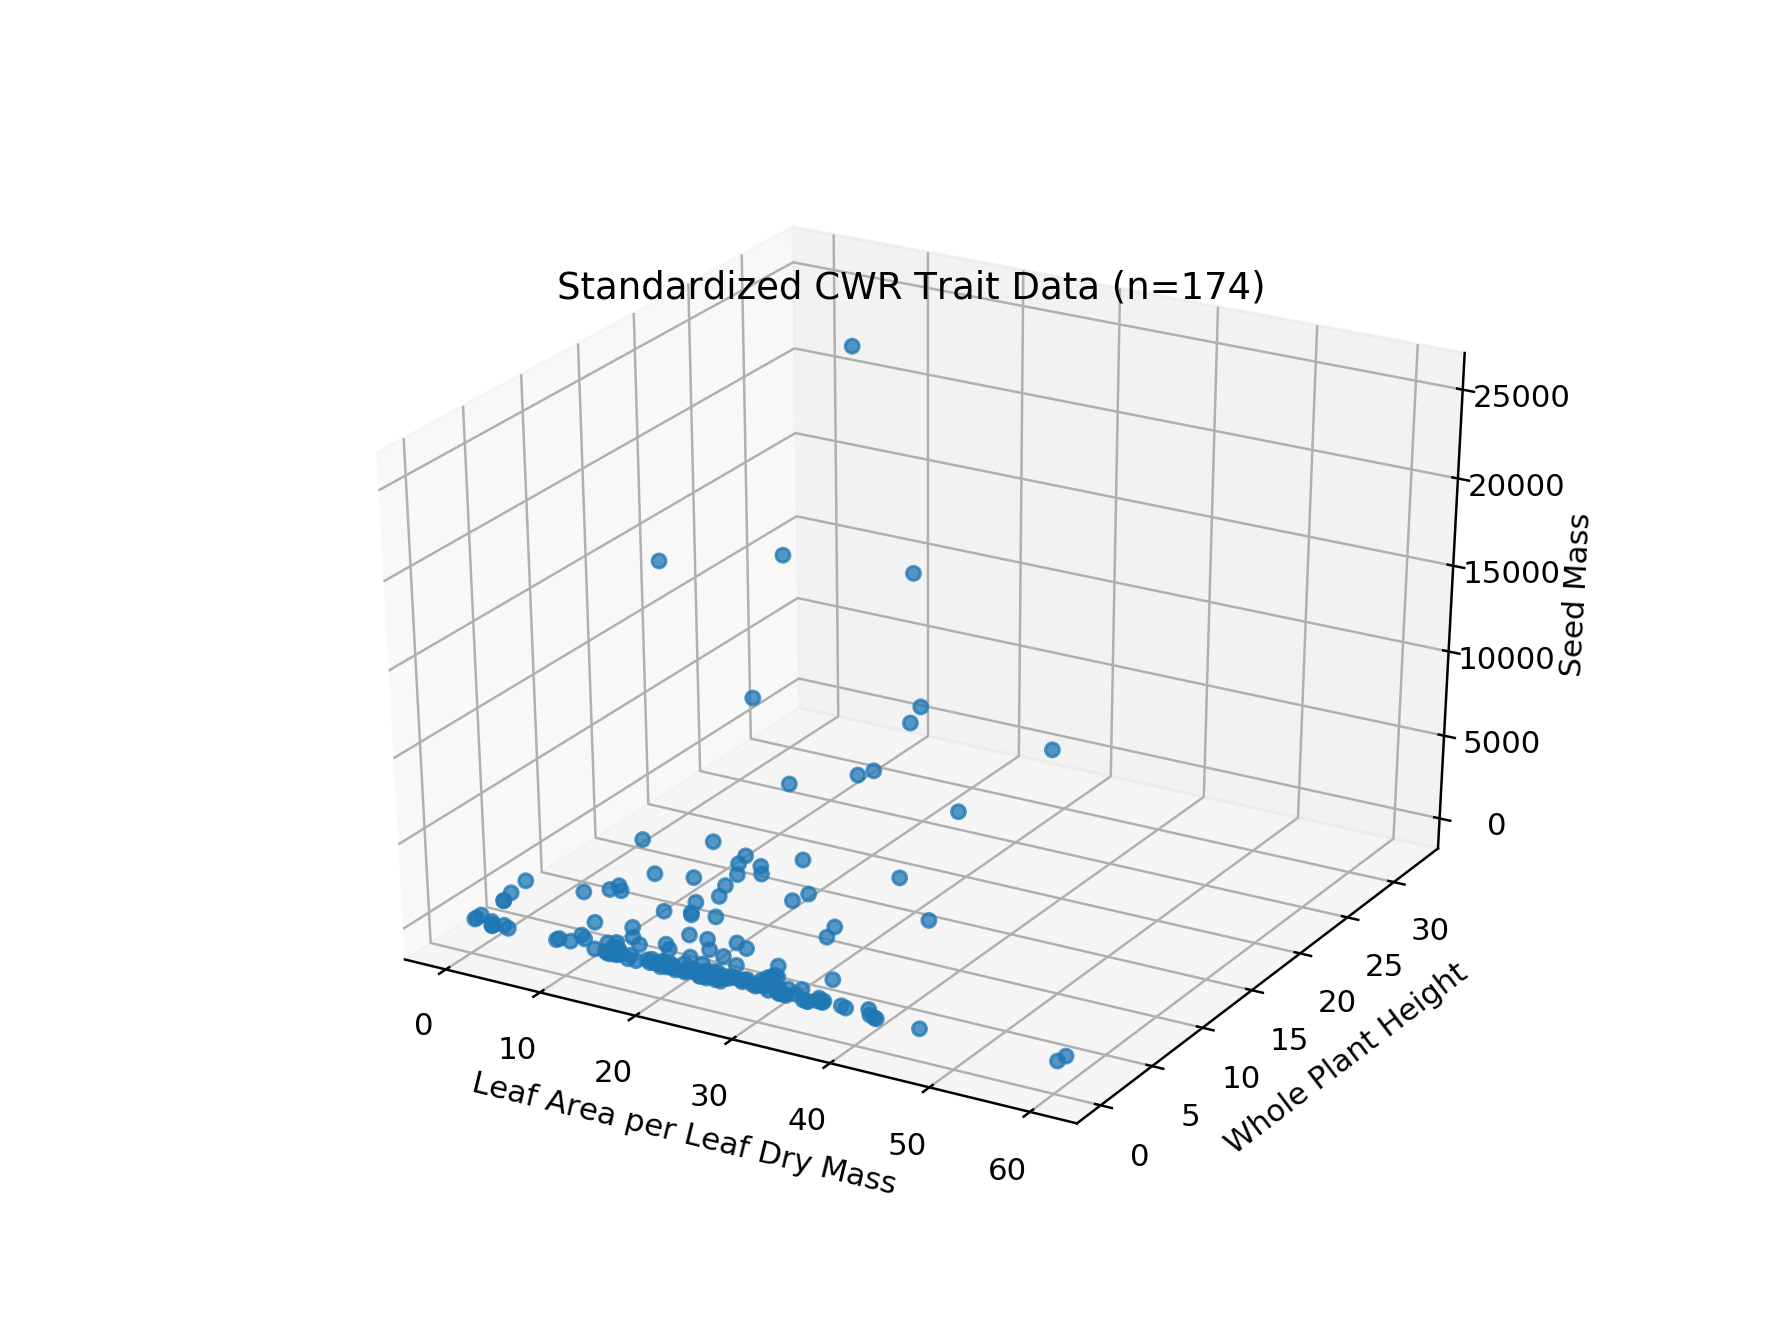

In [60]:
fig, ax = plot_3d(X)
ax.set_title(f"CWR Trait Data (n={trait_data.shape[0]})")
plt.show()

Let's run our implementation of K-Means on our trait data for $K=1,\dots,7$.

In [6]:
Ms = []
Cs = []
SSEs = []
for k in range(1, 8):
    C, SSE, M = KMeans(data=X, K=k, inits=30)

    Cs.append(C)
    SSEs.append(SSE)
    Ms.append(M)

Ms = np.array(Ms)

Now we can create an elbow plot to choose what appears to be the best value of $K$. On the right subplot, I use $\sqrt{W(C)}$ to better visualize the "elbow" since we are dealing with such large values of within-cluster scatter.

<IPython.core.display.Javascript object>


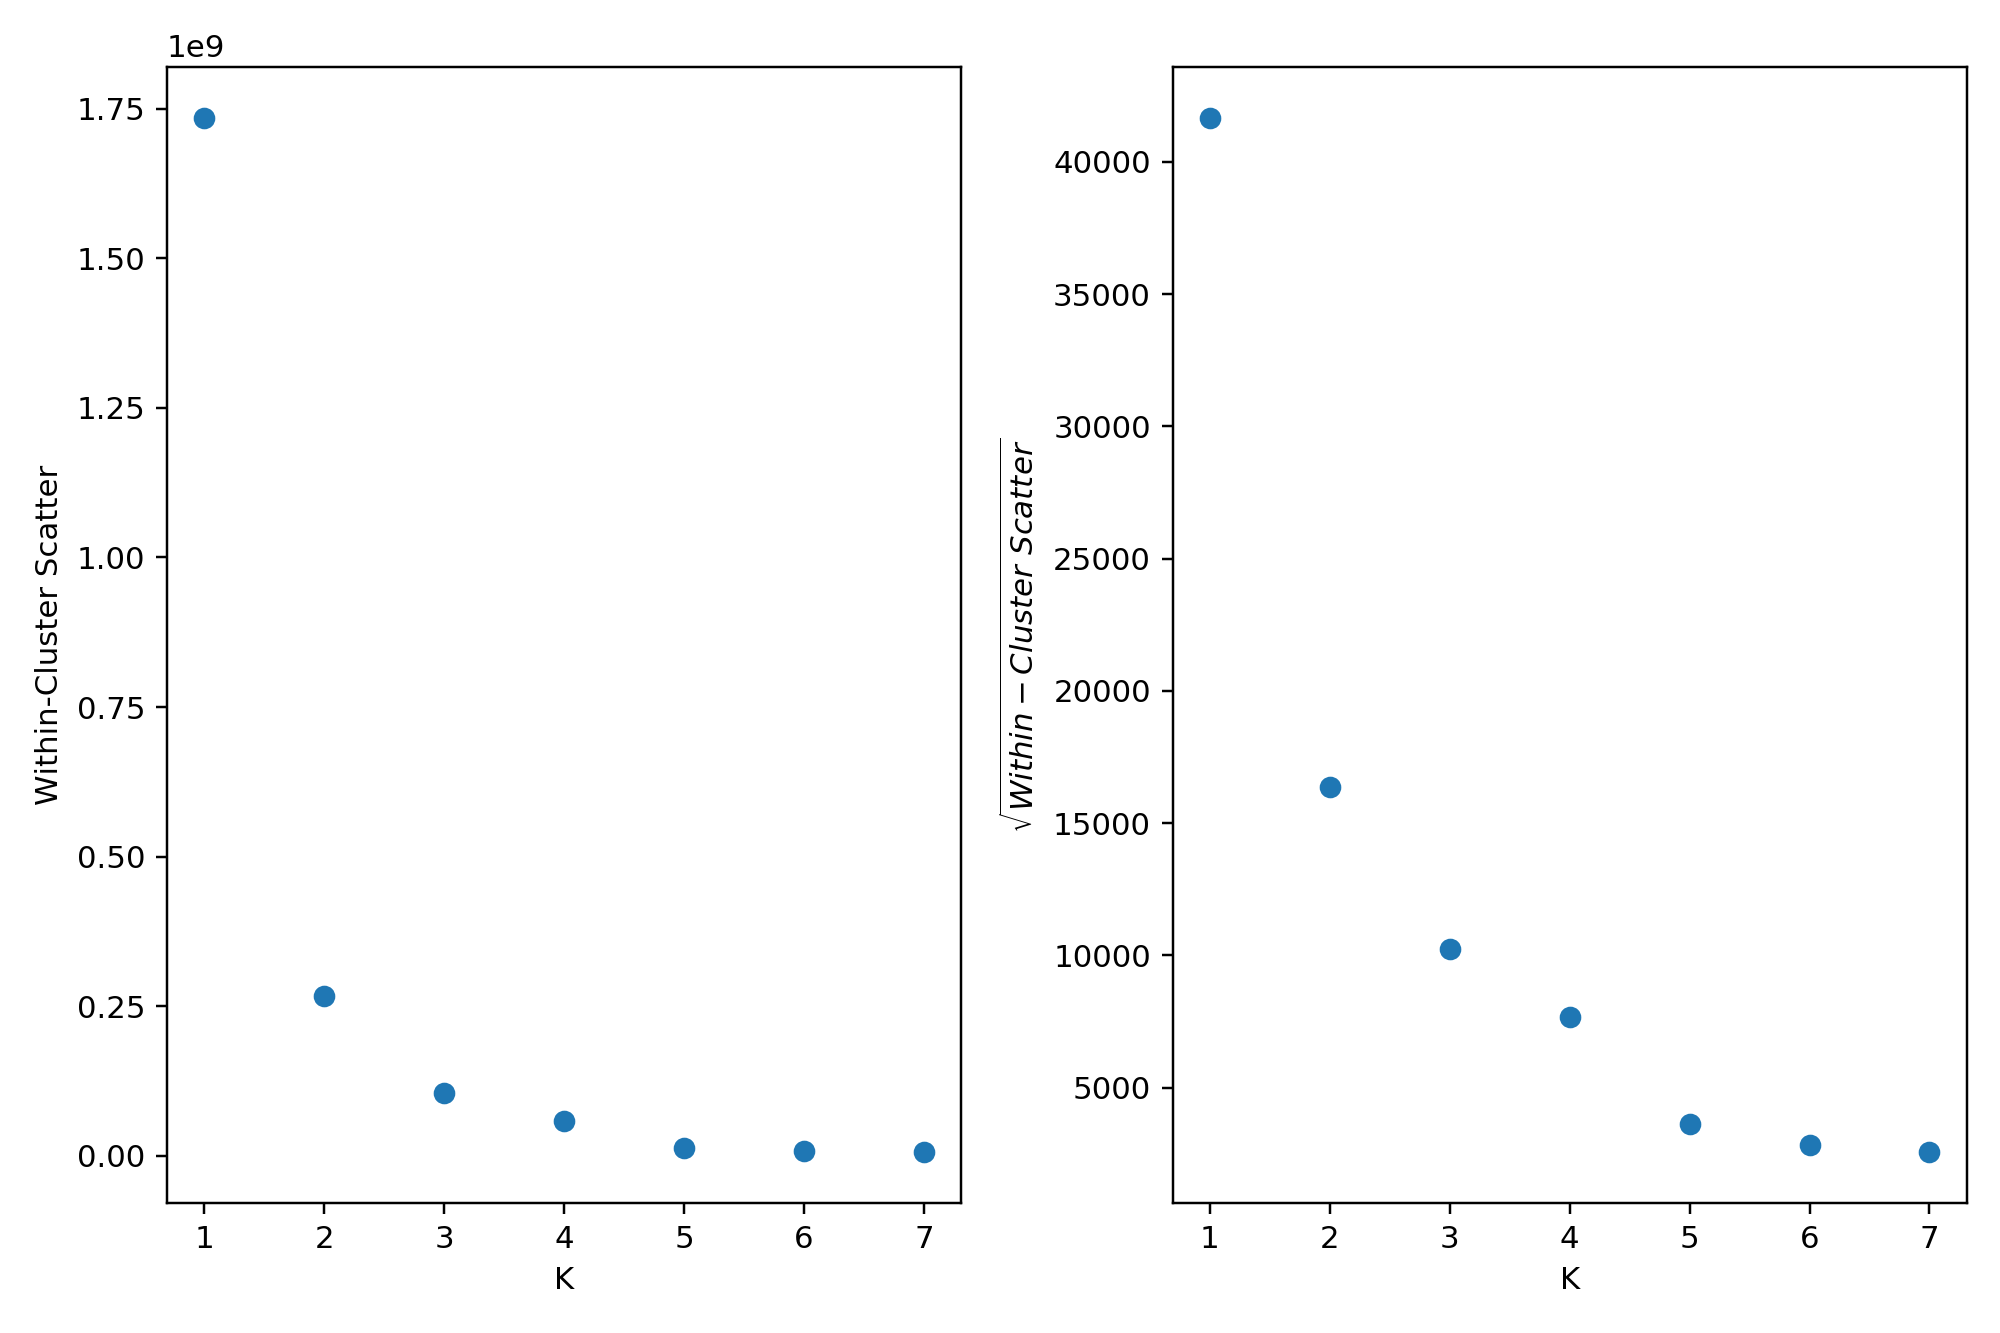

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(9,6))
ax[0].scatter(list(range(1, 8)), SSEs)
ax[0].set(xlabel = "K", ylabel = "Within-Cluster Scatter")
ax[1].scatter(list(range(1, 8)), np.sqrt(SSEs))
ax[1].set(xlabel = "K", ylabel = "$\sqrt{Within-Cluster\ Scatter}$")
fig.tight_layout()
plt.show()

Based on the right subplot, it appears $K=5$ would be our best choice. At this point, increasing $K$ does not garner an appreciable decrease in within-cluster scatter. Let's visualize how our implementation partitions the data into $K=5$ clusters.

<IPython.core.display.Javascript object>


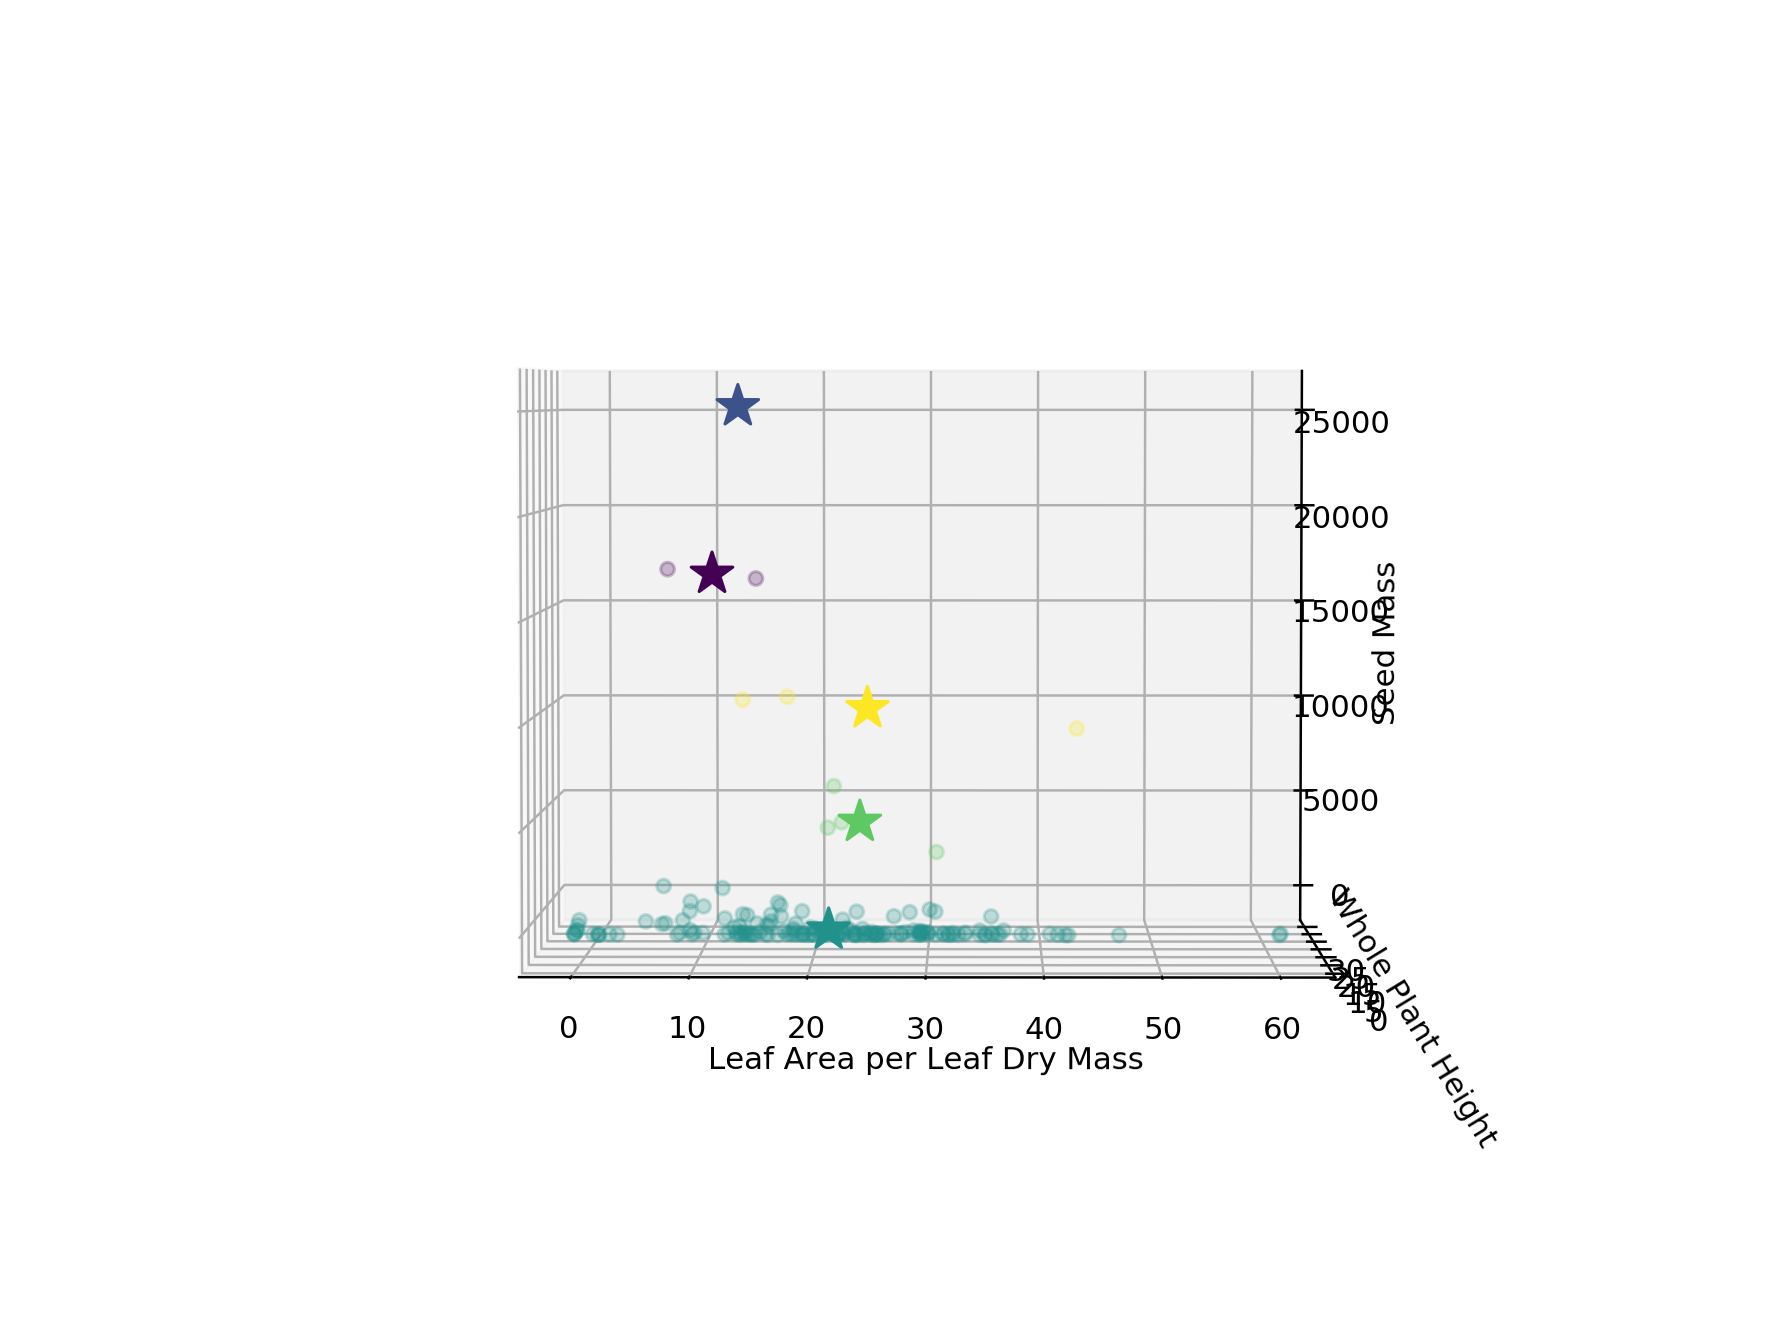

In [10]:
fig, ax = plot_3d(X, clustered=True, col=Cs[4], M=Ms[4])
plt.show()

This is a little disappointing since it appears we have clustered species by seed mass alone. Since the scale (and variation) of $X_3=SeedMass$ is so much greater than our other two attributes, the algorithm seems to find the "best" way to partition the data is solely by seed mass.

### Normalization
Let's now standardize each of our attributes (such that $X_j^{'}=\frac{X_j - \bar{X_j}}{\sqrt{var(X_j)}}$ for $j=1,2,3$) and re-run K-Means.

<IPython.core.display.Javascript object>


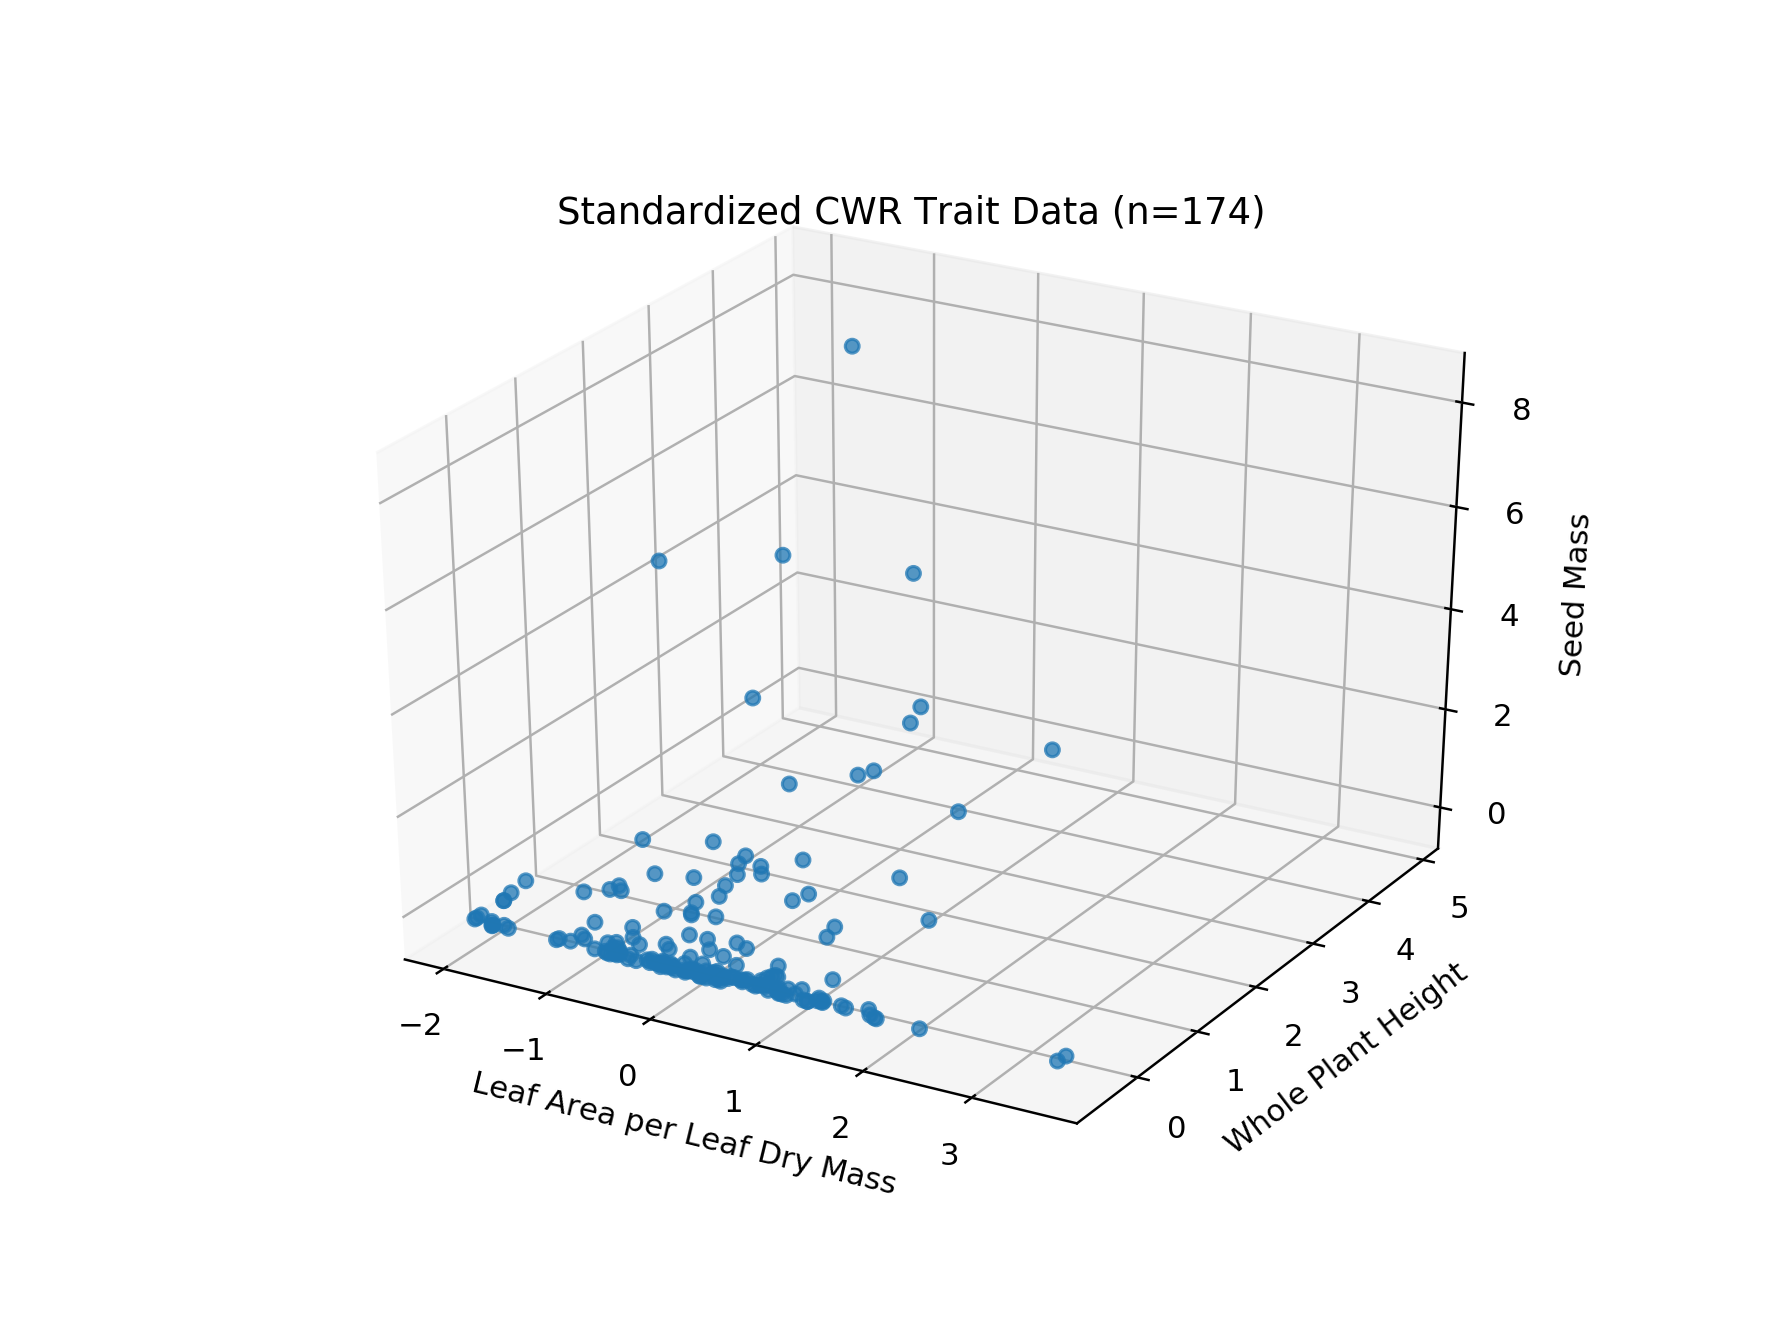

In [65]:
norm_X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

fig, ax = plot_3d(norm_X)
ax.set_title(f"Standardized CWR Trait Data (n={norm_X.shape[0]})")
plt.show()

Now let's run our implementation of K-Means vs. `sklearn`'s implementation on our standardized data for $K=1,\dots,7$.

In [14]:
Ms = []
Cs = []
SSEs = []
for k in range(1, 8):
    C, SSE, M = KMeans(data=norm_X, K=k, inits=30)

    Cs.append(C)
    SSEs.append(SSE)
    Ms.append(M)

Ms = np.array(Ms)

sk_Ms = []
sk_Cs = []
sk_SSEs = []
for k in range(1, 8):
    sk = cluster.KMeans(n_clusters=k, init="random", n_init=30,
                        random_state=0, max_iter=100).fit(norm_X)
    
    sk_Ms.append(sk.cluster_centers_)
    sk_Cs.append(sk.labels_)
    sk_SSEs.append(sk.inertia_)

sk_Ms = np.array(sk_Ms)

We can now create an elbow plot to choose our value of $K$. Interestingly, we see slight differences in $W(C)$ between our method and `sklearn`'s, particularly with $K=1$ and $K=7$. This likely just comes down to different random initializations leading to different local optima. 

<IPython.core.display.Javascript object>


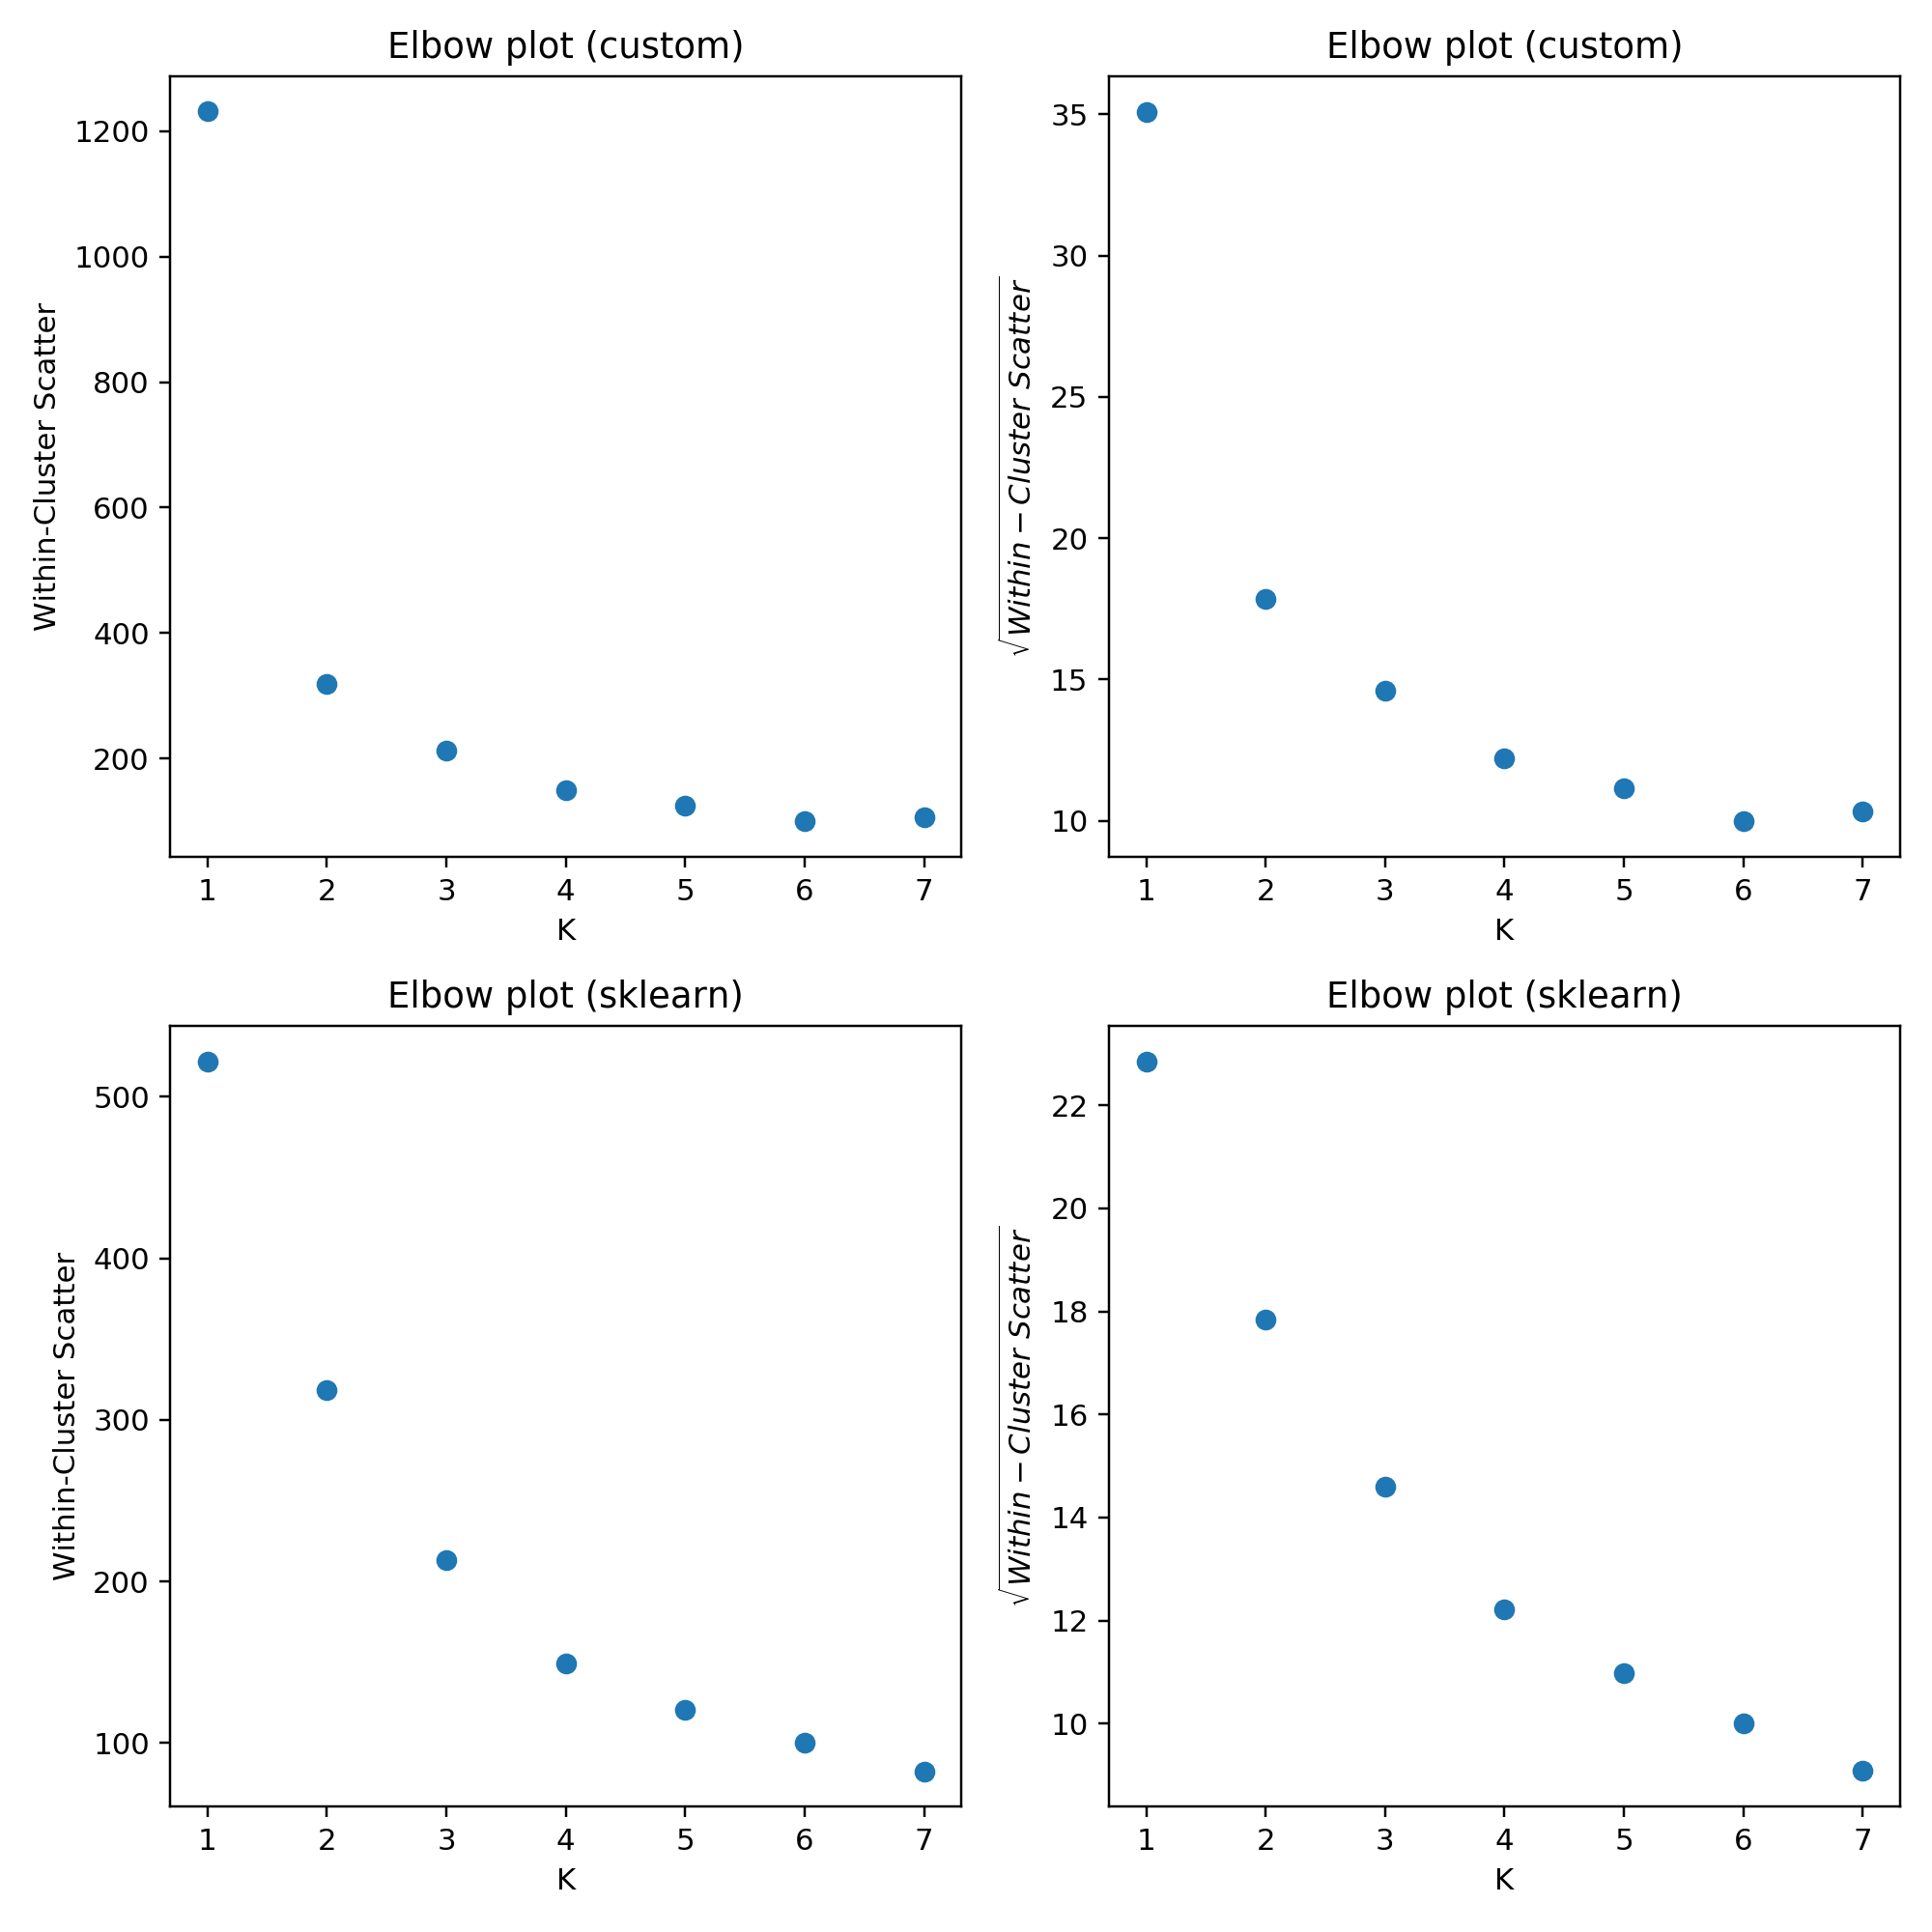

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(9,9))
ax[0, 0].scatter(list(range(1, 8)), SSEs)
ax[0, 0].set(xlabel = "K", ylabel = "Within-Cluster Scatter", title="Elbow plot (custom)")
ax[0, 1].scatter(list(range(1, 8)), np.sqrt(SSEs))
ax[0, 1].set(xlabel = "K", ylabel = "$\sqrt{Within-Cluster\ Scatter}$", title="Elbow plot (custom)")
ax[1, 0].scatter(list(range(1, 8)), sk_SSEs)
ax[1, 0].set(xlabel = "K", ylabel = "Within-Cluster Scatter", title="Elbow plot (sklearn)")
ax[1, 1].scatter(list(range(1, 8)), np.sqrt(sk_SSEs))
ax[1, 1].set(xlabel = "K", ylabel = "$\sqrt{Within-Cluster\ Scatter}$", title="Elbow plot (sklearn)")
fig.tight_layout()
plt.show()

Upon standardizing, $K=4$ appears to be the best choice, though we could also consider $K=6$. Let's visualize how our algorithm partitions the data into $K=4$ groups in comparison to `sklearn`'s approach.

<IPython.core.display.Javascript object>


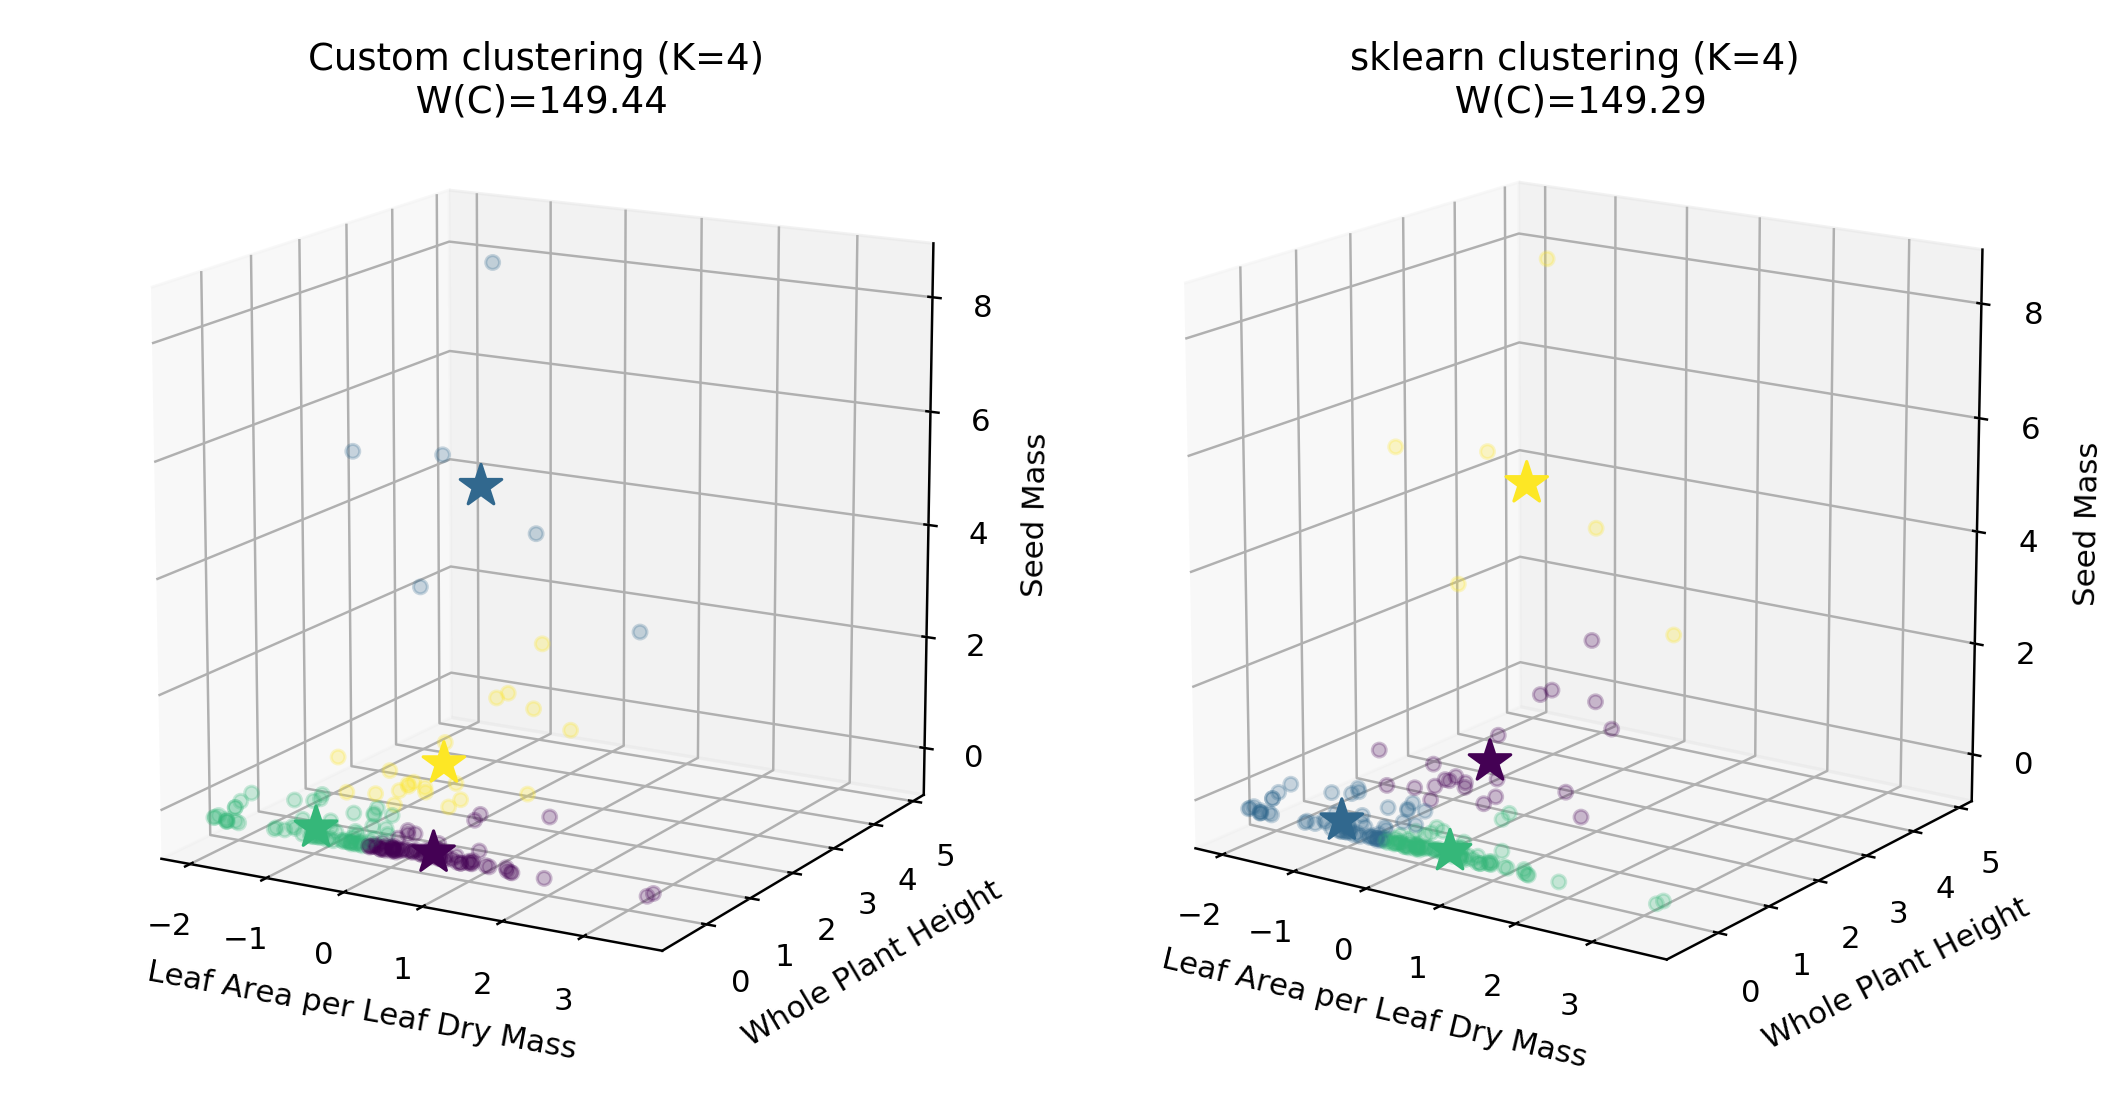

In [46]:
fig, ax = plot_3d_compare(norm_X, C1=Cs[3], C2=sk_Cs[3], M1=Ms[3], M2=sk_Ms[3])
ax[0].set_title(f"Custom clustering (K=4)\n W(C)={round(SSEs[3], 2)}")
ax[1].set_title(f"sklearn clustering (K=4)\n W(C)={round(sk_SSEs[3], 2)}")
fig.tight_layout()
plt.show()

It appears both implementations of K-Means have identified four qualitatively different groups of plants in this three-dimensional feature space (color in the left subplot):
1. small seeds, short, above average SLA (green)
2. small seeds, short, below average SLA (purple)
3. small-medium seeds, tall (yellow)
4. large seeds, tall (blue).

I find it particularly interesting that the boundary between clusters 1 and 2 is almost *exactly* at the sample mean SLA. This clearly captures more semantic structure in the data than our clustering of the raw data.

I would guess that this fourth cluster contains fruit-bearing trees (being tall with extremely large seeds). To see if that is the case, let's first look at our 4 centroids, the rows of this matrix:

In [53]:
Ms[3]

array([[ 0.8087341 , -0.42439288, -0.21267563],
       [-0.32845794,  2.53213447,  4.80195389],
       [-0.78159902, -0.29813023, -0.21344576],
       [-0.41764347,  1.83843269,  0.11923635]])

Clearly this fourth cluster is represented by the second row where $X_3=4.8$ (that is, 4.8 standard deviations greater than the mean seed size). Then we can find the six species in this cluster are...

In [55]:
idxs = np.where(Cs[3] == 1)[0]
for species in trait_data.loc[idxs, "Species"].tolist():
    print(species)

Castanea sativa
Juglans australis
Juglans hindsii
Mangifera indica
Piper tucumanum
Solanum riparium


As expected, these are all fruit-bearing trees! (image examples?)

Now let's look at the results with $K=6$.

<IPython.core.display.Javascript object>


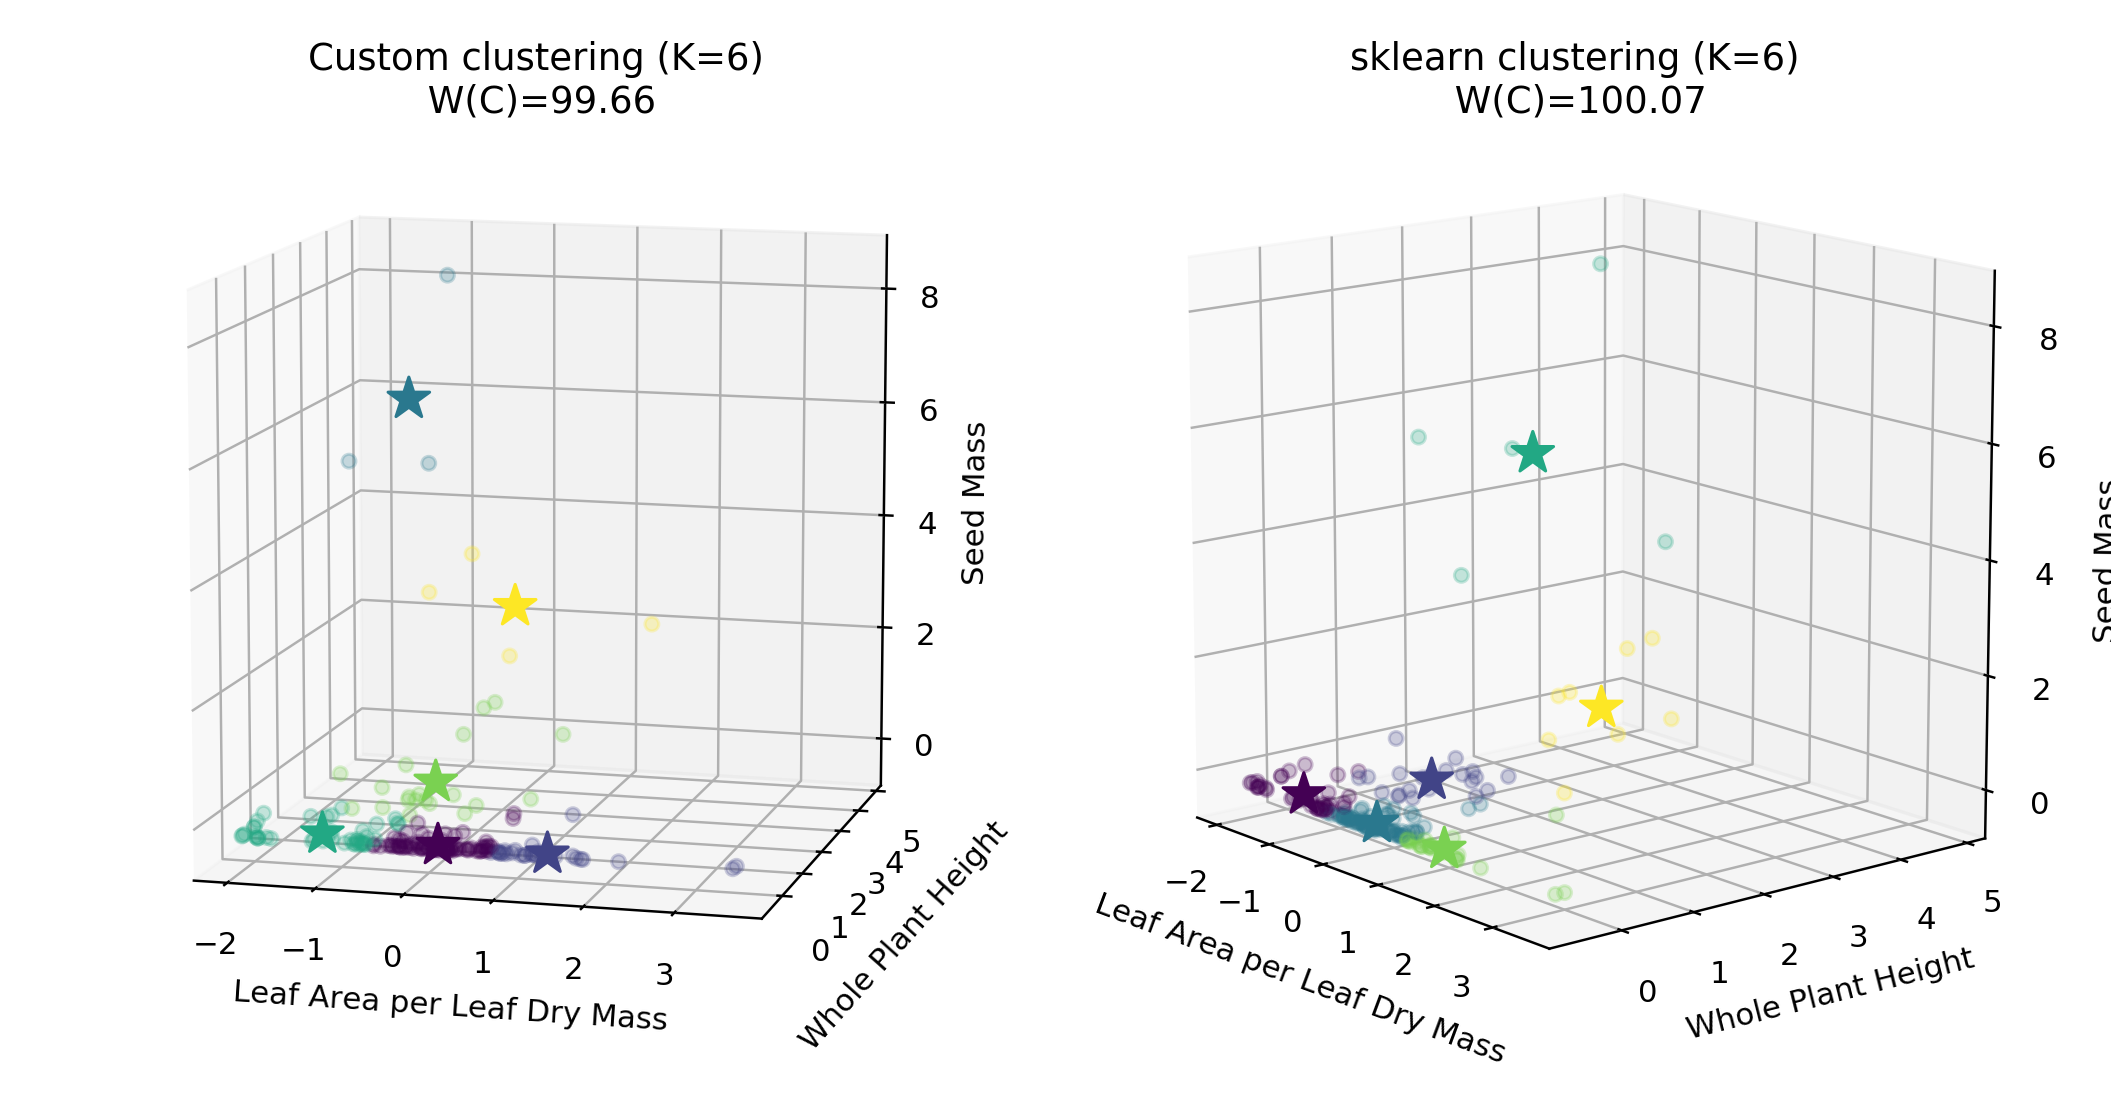

In [48]:
fig, ax = plot_3d_compare(norm_X, C1=Cs[5], C2=sk_Cs[5], M1=Ms[5], M2=sk_Ms[5])
ax[0].set_title(f"Custom clustering (K=6)\n W(C)={round(SSEs[5], 2)}")
ax[1].set_title(f"sklearn clustering (K=6)\n W(C)={round(sk_SSEs[5], 2)}")
fig.tight_layout()
plt.show()

Now we see the following groups (from our custom implementation):
1. small seeds, short, small SLA (dark green)
2. small seeds, short, average SLA (purple)
3. small seeds, short, large SLA (blue)
4. small seeds, tall, below average SLA (light green)
5. large seeds, tall (yellow)
6. extremely large seeds, tall (teal).

It appears the clustering with `sklearn` reached a slightly different optimum. The clusters are quite similar except for differences in clusters 4-6.

Qualitatively, we can see the results are extremely similar. It is important to note that even with slightly different values of $W(C)$, the two methods can produce the exact same clusters of plants. The difference in $W(C)$ may only be a result of slightly more optimal centroid placement in the feature space.

In [51]:
for k in range(4):
    idxs = np.where(Cs[3] == k)[0]

    print("-----")
    print(f"Species in cluster {k + 1} (centroid = {Ms[3][k, :]}):")
    for species in trait_data.loc[idxs, "Species"].tolist():
        print("\t", species)


-----
Species in cluster 1 (centroid = [ 0.8087341  -0.42439288 -0.21267563]):
	 Amaranthus blitum
	 Avena barbata
	 Avena fatua
	 Avena sativa
	 Avena sterilis
	 Avena strigosa
	 Barbarea vulgaris
	 Brassica nigra
	 Brassica oleracea
	 Brassica rapa
	 Chenopodium album
	 Chenopodium ambrosioides
	 Chenopodium hybridum
	 Chenopodium polyspermum
	 Chenopodium vulvaria
	 Corylus cornuta
	 Digitaria ischaemum
	 Digitaria sanguinalis
	 Diplotaxis tenuifolia
	 Echinochloa crus-galli
	 Eleusine indica
	 Elymus caninus
	 Elymus glaucus
	 Elymus repens
	 Eragrostis pilosa
	 Fragaria vesca
	 Hordeum distichon
	 Hordeum jubatum
	 Hordeum marinum
	 Hordeum murinum
	 Ilex verticillata
	 Jacaratia spinosa
	 Lactuca muralis
	 Lactuca serriola
	 Lathyrus odoratus
	 Lathyrus palustris
	 Lathyrus sativus
	 Lepidium campestre
	 Lepidium densiflorum
	 Lepidium virginicum
	 Linum perenne
	 Lupinus luteus
	 Medicago arabica
	 Medicago lupulina
	 Medicago minima
	 Medicago sativa
	 Mentha aquatica
	 Mentha 